In [19]:
from scipy import ndimage, sparse
from scipy.linalg import eigh, inv, logm, norm
import scipy.sparse
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob

In [20]:
def edges_rescaling(edges,scale): # edges are mat.data where mat is a sparse scipy matrix
    edges = np.log10(edges) # log rescale weights because they vary over many decades
    edges -= min(edges) # make them positive 
    edges /= max(edges)*1.0/scale # rescale from 0 to scale
    return edges

def build_omegaij(Kdata,Krow,Kcol,m):
    omegaIJ_data = np.zeros(Kdata.shape)
    omegaIJ_data = np.asfarray([Kdata[ind]*(1.0/m[Krow[ind]] + 1.0/m[Kcol[ind]]) for ind in range(omegaIJ_data.shape[0])])
    omegaIJ = sparse.coo_matrix((omegaIJ_data, (Krow, Kcol)), shape=(Krow.max()+1,Kcol.max()+1))
    return omegaIJ
def build_omegai(K,m):
    omegaI = 0.5*np.divide(K.sum(axis=1),m.reshape((m.shape[0],1))) #0.5 to avoid double counting
    return omegaI

def remove_col(mat,index_to_drop): #csr
    to_keep = list(set(range(mat.shape[1]))-set(index_to_drop))    
    mat = mat[:,to_keep]
    return mat
def remove_row(mat,index_to_drop): #csc
    to_keep = list(set(range(mat.shape[0]))-set(index_to_drop))    
    mat = mat[to_keep,:]
    return mat
def remove_2nodes(mat,nodes):
    mat = mat.tocoo()
    todrop1 = np.logical_or((mat.row==nodes[0]),(mat.row==nodes[1])).nonzero()[0]
    todrop2 = np.logical_or((mat.col==nodes[0]),(mat.col==nodes[1])).nonzero()[0]
    todrop = list(set(np.concatenate((todrop1,todrop2))))
    newdata=np.delete(mat.data,todrop)
    newrow=np.delete(mat.row,todrop)
    newcol=np.delete(mat.col,todrop)
    return sparse.coo_matrix((newdata, (newrow, newcol)), shape=mat.shape)
def remove_1node(mat,node):
    mat = mat.tocoo()
    todrop = np.logical_or((mat.row==node[0]),(mat.col==node[0])).nonzero()[0]
    todrop = list(set(todrop))
    newdata=np.delete(mat.data,todrop)
    newrow=np.delete(mat.row,todrop)
    newcol=np.delete(mat.col,todrop)
    return sparse.coo_matrix((newdata, (newrow, newcol)), shape=mat.shape)
def expand(Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol,idxs,m,g):
    for idx in idxs:
        newdata=K.data[idx]
        j=K.col[idx]
        #add (g,j,newdata)
        Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol = expand1(Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol,newdata,m,g,j)
    return Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol
def expand1(Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol,newk,m,i,j):
    Kdata = np.append(Kdata,newk)
    Krow = np.append(Krow,i)
    Kcol = np.append(Kcol,j)
    omegaIJdata = np.append(omegaIJdata,newk*(1.0/m[i]+1.0/m[j]))
    omegaIJrow = np.append(omegaIJrow,i)
    omegaIJcol = np.append(omegaIJcol,j)
    #add symmetric
    Kdata = np.append(Kdata,newk)
    Krow = np.append(Krow,j)
    Kcol = np.append(Kcol,i)
    omegaIJdata = np.append(omegaIJdata,newk*(1.0/m[i]+1.0/m[j]))
    omegaIJrow = np.append(omegaIJrow,j)
    omegaIJcol = np.append(omegaIJcol,i)
    return Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol
def delete_nodes(Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol,idxs): #this is not symm wrt to (i,j)
    Kdata = np.delete(Kdata,idxs)
    Krow = np.delete(Krow,idxs)
    Kcol = np.delete(Kcol,idxs)
    omegaIJdata = np.delete(omegaIJdata,idxs)
    omegaIJrow = np.delete(omegaIJrow,idxs)
    omegaIJcol = np.delete(omegaIJcol,idxs)
    return Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol

In [42]:
filename='/home/garner1/Work/pipelines/tissue2graph/npz/mat_XY_10nn.npz'
K0 = sparse.load_npz(filename)

N = 500
K = K0.copy()[:N,:N].tocoo()  #make a copy of the initial data
m = np.ones(K0.shape[0])[:N] #initial masses

data = np.load('/home/garner1/Work/pipelines/tissue2graph/npz/X-XY_data.npz',allow_pickle=True)
pos = data['XY'][:N,:]

# K = K0.copy().tocoo()  #make a copy of the initial data
# m = np.ones(K0.shape[0]) #initial masses

In [43]:
import networkx as nx
import seaborn as sns; sns.set()
sns.set(style='white', rc={'figure.figsize':(50,50)})

init_mat = sparse.coo_matrix((K.data, (K.row, K.col)), shape=(K.row.max()+1, K.col.max()+1))

G = nx.from_scipy_sparse_matrix(init_mat) # if sparse matrix
eset = [(u, v) for (u, v, d) in G.edges(data=True)]
weights = [d['weight'] for (u, v, d) in G.edges(data=True)]

nx.draw_networkx_nodes(G, pos,alpha=0.0)
nx.draw_networkx_edges(G, pos, edgelist=eset,alpha=1.0, width=weights,edge_color='r',style='solid')
plt.axis('off')

plt.savefig('./before_RG_monthus.png',bbox_inches='tight')
plt.close()

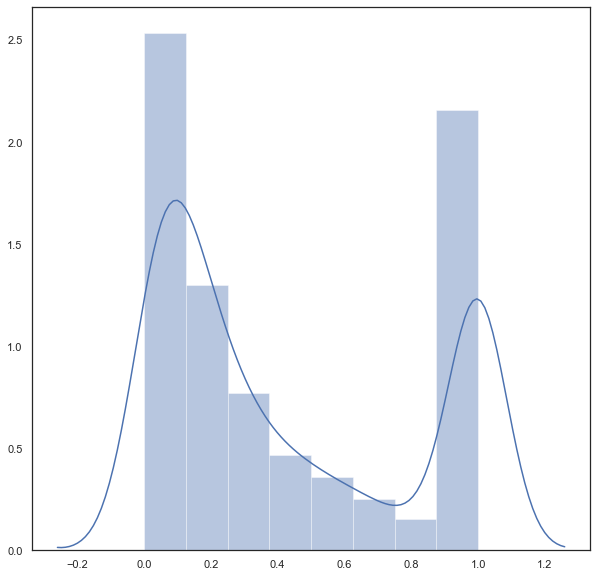

In [44]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.distplot(weights)

In [45]:
omegaIJ = build_omegaij(K.data,K.row,K.col,m)
omegaI = build_omegai(K,m) 

# %%time
'''RG flow'''
# for counter in range(2*N):
condition = True
Imax0 = 0
IJmax0 = 0
while condition:
    #Find max btw node and edges
    IJmax = omegaIJ.data.max()
    Imax = omegaI.max()
    maxtype = np.argmax([Imax,IJmax])
    condition = (abs(Imax-Imax0) > 1e-06) or (abs(IJmax-IJmax0) > 1e-06)
    Imax0 = Imax; IJmax0 = IJmax
    print([Imax,IJmax],np.count_nonzero(omegaI),omegaIJ.data.shape[0])
    if maxtype==1: #if edge
        emax = omegaIJ.data.argmax() #idx of emax
        i0 = K.row[emax];j0 = K.col[emax] #find max edge (i0,j0)  
        m = np.append(m,m[i0]+m[j0]) #add a center of mass node
        g = K.row.max()+1 # label the i0-j0 center of mass node
        print(pos.shape,g)
        pos = np.vstack((pos,[0.5*pos[i0,0]+0.5*pos[j0,0],0.5*pos[i0,1]+0.5*pos[j0,1]]))
        idx_i0isrow = np.argwhere(K.row==i0) # idxs of (i0,j)
        idx_i0iscol = np.argwhere(K.col==i0) # idxs of (j,i0)
        idx_j0isrow = np.argwhere(K.row==j0) # idxs of (j0,i)
        idx_j0iscol = np.argwhere(K.col==j0) # idxs of (i,j0)
        js = np.setdiff1d([K.col[idx] for idx in np.union1d(idx_i0isrow,idx_j0isrow)],[i0,j0]) #nodes neighbours of i0 and j0
        for j in  js:
            idx_i0j = np.intersect1d(np.argwhere(K.row==i0),np.argwhere(K.col==j))
            idx_j0j = np.intersect1d(np.argwhere(K.row==j0),np.argwhere(K.col==j))
            newk = np.sum(np.append(K.data[idx_i0j],K.data[idx_j0j]))
            K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = expand1(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,newk,m,g,j)
            #remove i0 and j0 from K, omegaIJ
            K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.intersect1d(np.argwhere(K.row==i0),np.argwhere(K.col==j)))
            K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.intersect1d(np.argwhere(K.row==j),np.argwhere(K.col==i0)))
            K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.intersect1d(np.argwhere(K.row==j0),np.argwhere(K.col==j)))
            K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.intersect1d(np.argwhere(K.row==j),np.argwhere(K.col==j0)))
            #remove (i0,j0) from K, omegaIJ
            K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.intersect1d(np.argwhere(K.row==i0),np.argwhere(K.col==j0)))
            K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.intersect1d(np.argwhere(K.row==j0),np.argwhere(K.col==i0)))
        #update omegaI
        omegaI_g = np.array(sum([K.data[idx] for idx in np.argwhere(K.row==g)])*1.0/m[g]).reshape(1,1)
        omegaI = np.append(omegaI,omegaI_g,0)
        for j in js:
            omegaI[j] = sum([K.data[idx] for idx in np.argwhere(K.row==j)])*1.0/m[j]
        omegaI[i0] = 0.0; omegaI[j0] = 0.0
        
    if maxtype==0: #if node
        i0 = omegaI.argmax(axis=None) #node of highest frequency
        idx_i0isrow = np.argwhere(K.row==i0) # idxs of (i0,j)
        idx_i0iscol = np.argwhere(K.col==i0) # idx of (i,i0)
        js = np.unique(K.col[idx_i0isrow]) # nn j in (i0,j)
        count = 0
        for i in js:
            for j in js[np.argwhere(js==i)[0][0]+1:]:
                idx_ij = np.intersect1d(np.argwhere(K.row==i),np.argwhere(K.col==j))
                idx_ji = np.intersect1d(np.argwhere(K.row==j),np.argwhere(K.col==i))
                idx_ii0 = np.intersect1d(np.argwhere(K.row==i),np.argwhere(K.col==i0))    
                idx_i0j = np.intersect1d(np.argwhere(K.row==i0),np.argwhere(K.col==j))
#                 if idx_ij.shape[0]>0 and idx_ii0.shape[0]>0 and idx_i0j.shape[0]>0: # also if edge (i,j) exists
                if idx_ii0.shape[0]>0 and idx_i0j.shape[0]>0: # only if edge (i,i0) and (i0,j) exists
                    newk = np.sum(np.append(K.data[idx_ij],K.data[idx_ii0]*K.data[idx_i0j]*1.0/(omegaI[i0]*m[i0])))
                    #update edge values
                    K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = expand1(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,newk,m,i,j)
                    #remove old (i,j) and (j,i)
                    K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,idx_ij)
                    K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,idx_ji)
        #remove i0 from K, omegaIJ
        K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.argwhere(K.row==i0))
        K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.argwhere(K.col==i0))
        #update omegaI
        for j in js:
            omegaI[j] = sum([K.data[idx] for idx in np.argwhere(K.row==j)])*1.0/m[j]
        #remove i0 omegaI
        omegaI[i0] = 0.0

[3.1290398436932607, 2.0] 500 4744
[7.024935513103458, 2.639173708200329] 499 4843
[7.571495620450834, 2.6638611232943696] 498 4850
[4.867606215577427, 2.7645909319478466] 497 4837
[4.427378454308932, 2.099887354927083] 496 4854
[4.106128773018034, 2.0162005608346827] 495 4885
[5.804875249326612, 2.246508721250863] 494 4968
[4.04039928340713, 2.274164112512653] 493 5023
[3.8344649763280527, 2.274164112512653] 492 4995
[4.482709878243966, 2.051454255626562] 491 5007
[5.983618892249274, 2.7908521523525986] 490 5079
[4.45101322322924, 2.4785014440622444] 489 5128
[5.084280662590432, 2.4785015106758284] 488 5226
[6.72302250071615, 2.4785015106758284] 487 5389
[6.1661256828821775, 2.4785015106758284] 486 5375
[4.66294666649891, 2.4785015106758284] 485 5372
[4.647021986457757, 2.4785015106758284] 484 5372
[6.207727335040834, 2.4785015106758284] 483 5365
[4.641150081815696, 2.4785015106758284] 482 5384
[4.5361170598263385, 2.431409315618854] 481 5388
[4.142237359688755, 2.3280350618028898] 48

[2.7788569666377994, 2.542268395690614] 333 14745
[2.719024392156028, 2.542268395690614] 332 14734
[3.8539473736694934, 2.542268395690614] 331 15982
[3.573470291175018, 2.542268395690614] 330 15937
[2.676438993402245, 2.542268395690614] 330 15893
[2.6643759290347364, 2.542268395690614] 329 15832
[5.660396517902562, 2.6692490648729157] 328 15830
[3.7268913982161838, 2.5622040356881617] 327 15826
[2.662806164458981, 2.542268395690614] 326 15814
[2.640723509468635, 2.3255648179385875] 325 15877
[2.6122184262413133, 2.3255648179385875] 324 15851
[2.4545143033856642, 2.3255648179385875] 323 15844
[2.358385327470243, 2.302400227212741] 322 15771
[2.3180457825592997, 2.2712370183796646] 321 15742
[2.287010192057116, 2.2712370183796646] 320 15735
[2.2702790174134937, 2.2712370183796646] 319 15936
(501, 2) 500
[2.2702790174134937, 2.1674783829760815] 318 15898
[5.7475894003926005, 2.715964484875606] 317 15911
[3.051535020326262, 2.1674783829760815] 316 15907
[2.620033941742291, 2.16747838297608

In [46]:
fixed_mat = sparse.coo_matrix((K.data, (K.row, K.col)), shape=(K.row.max()+1, K.col.max()+1))

import networkx as nx
import seaborn as sns; sns.set()
sns.set(style='white', rc={'figure.figsize':(50,50)})
G = nx.from_scipy_sparse_matrix(fixed_mat) # if sparse matrix
eset = [(u, v) for (u, v, d) in G.edges(data=True)]
weights = [d['weight'] for (u, v, d) in G.edges(data=True)]

nx.draw_networkx_nodes(G, pos,alpha=0.0)
nx.draw_networkx_edges(G, pos, edgelist=eset,alpha=1.0, width=weights,edge_color='r',style='solid')
plt.axis('off')

plt.savefig('./after_RG_monthus.png',bbox_inches='tight')
plt.close()


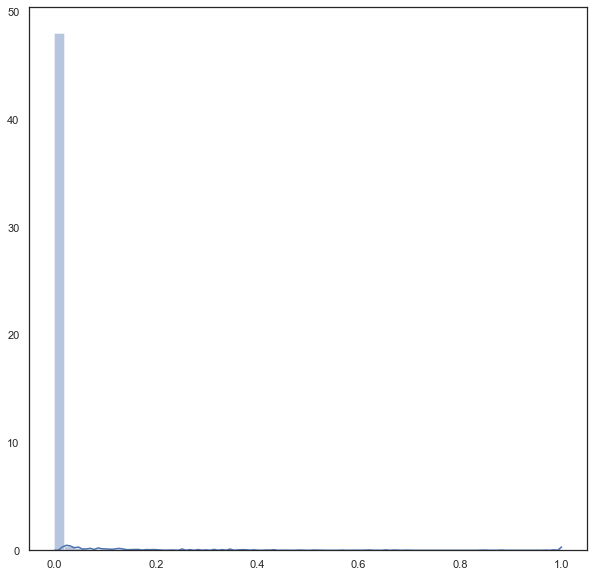

In [47]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.distplot(weights)

In [27]:
pos.shape

(1036002, 2)

In [29]:
K.row.max()

1007